# 🚢 Titanic dataset with logistic regression and roc curve

# 📚 Import Libraries

In [2]:
# import base libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ❎ Ignore warnings

In [411]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# 📂 Initial settup

In [4]:
# train the testing data
test = pd.read_csv('test.csv')

# load the training data
train = pd.read_csv('train.csv')

In [160]:
# lets look at the shape of the training and testing data we have
print('testing : ',test.shape)
print('training : ',train.shape)

testing :  (418, 11)
training :  (891, 12)


# 🔍 Data quality assesment and data cleaning

### Checking for null values in `train` 

In [164]:
null = train.isnull().sum().reset_index().sort_values(by=0, ascending=False)
null['percentage'] = (null[0]/len(train)*100)
null.columns=['Features','Number of null','Percentage']
null.head(3)

,Features,Number of null,Percentage
10,Cabin,687,77.104377
5,Age,177,19.865320
11,Embarked,2,0.224467


### Checking for null values in `test` 

In [167]:
null = test.isnull().sum().reset_index().sort_values(by=0, ascending=False)
null['percentage'] = (null[0]/len(test)*100)
null.columns=['Features','Number of null','Percentage']
null.head(3)

,Features,Number of null,Percentage
9,Cabin,327,78.229665
4,Age,86,20.574163
8,Fare,1,0.239234


### lets try to look at the null values in a bigger picture

In [170]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<Axes: >

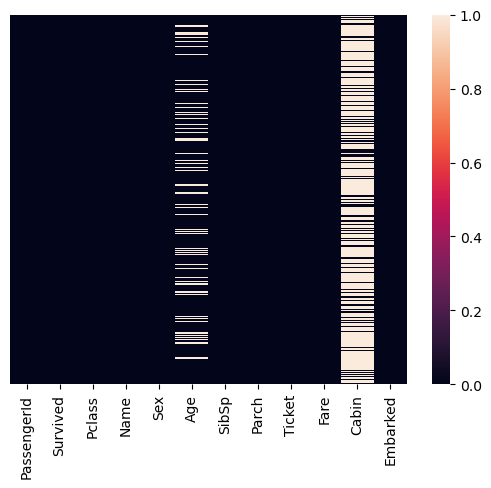

In [172]:
# heatmap of null values
sns.heatmap(train.isnull(),yticklabels=False,cbar=True)

**Interpretation of null values**
- there are two column with major null values, which is `Age` and `Cabin`
- `Cabin` feature has a lot of null values, and its evenly distrubuted
- and for `Age` there are a lot of null values, but not as crazy as `Cabin` so we can still do something about it

### Fixing null values for `Age`

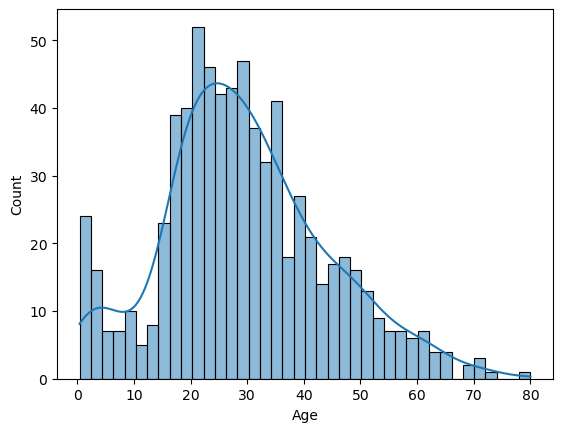

In [176]:
sns.histplot(data=train, x='Age', kde=True, bins=40)
plt.show()

### So here are some solutions that we can do
* Using `sklearn` or K-Nearest Neighbor
* Using the average value
* Using adjusted average value with `Pclass` and `Age`

In [179]:
# dataset for K-Nearest Neighbor
train1 = train.copy()
# dataset for K-Nearest Neighbor
train2 = train.copy()
# dataset for K-Nearest Neighbor
train3 = train.copy()

### Using K-Nearest Neighbor

In [182]:
import pandas as pd
from sklearn.impute import KNNImputer

# Assuming 'train' is your DataFrame
# Create a KNN imputer instance
imputer = KNNImputer(n_neighbors=5)

# Select relevant columns for imputation (excluding non-numeric columns)
numeric_columns = train1.select_dtypes(include=['float64', 'int64']).columns

# Fit and transform the data to fill missing values
train1[numeric_columns] = imputer.fit_transform(train1[numeric_columns])

In [198]:
train1['Age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


### Using average value

In [202]:
# fill the null values wirh median values
train2['Age'] = train2['Age'].fillna(train2['Age'].mean())

In [204]:
train2['Age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


### Using adjusted average value

In [222]:
train3.groupby('Pclass')['Age'].mean()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [224]:
def age(column):
    age = column.iloc[0]
    pclass = column.iloc[1]
    
    if pd.isnull(age) : # if age is null 
        if pclass == 1 :
            return 37.048
        elif pclass == 2 :
            return 29.866
        else :
            return 26.403 
    else :
        return age # if age is not a null value just return age

train3['Age'] = train3[['Age','Pclass']].apply(age, axis=1)

markdown
The `age` function calculates a passenger's age based on their 'Age' and 'Pclass' values. If the age is missing (null), it returns an average age based on the passenger's class:
- Class 1: 37.048
- Class 2: 29.866
- Class 3: 26.403
If the age is not missing, it simply returns the provided age. This function is applied to the 'Age' and 'Pclass' columns of the `train3` DataFrame to fill in missing age values.

In [226]:
train3['Age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


### Machine learning comparison 

### ROC and AUC for `train1`

In [416]:
def ROC(train):
    from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
    # import the model
    from sklearn.ensemble import RandomForestClassifier
    # import the preprocessing module
    from sklearn.preprocessing import StandardScaler
    # Model evaluation
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


    # make the categorical data
    categorical_dirty = train[['Sex','Embarked']]
    categorical = pd.get_dummies(categorical_dirty, drop_first=True).astype(int)
    
    # make continuous featues
    continuous = train.select_dtypes(include='number')
    # evening out some features with a lot of outliers and high deviation
    continuous['Fare'] = continuous['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
    # apply standard scaler to just the continuous variables
    continuous[['Fare','Age']] = StandardScaler().fit_transform(continuous[['Fare','Age']])

    # combine both table into one
    training = pd.concat([categorical,continuous],axis=1)
    # define x and y
    x = training[['Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass', 'Age',
                  'SibSp', 'Parch', 'Fare']]
    y = training['Survived']
    
    # split the data
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)
    
    # doing machine learning
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train, y_train)
    
    # predict 
    # Make predictions on the test set
    y_pred = model.predict(x_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)


    y_pred_proba = model.predict_proba(x_test)[:, 1] 
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

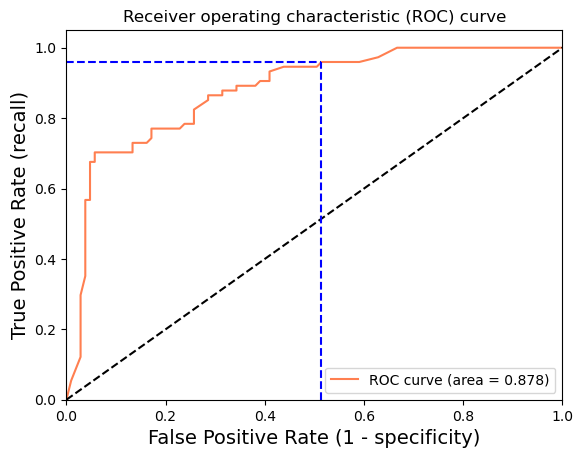

In [418]:
ROC(train1)

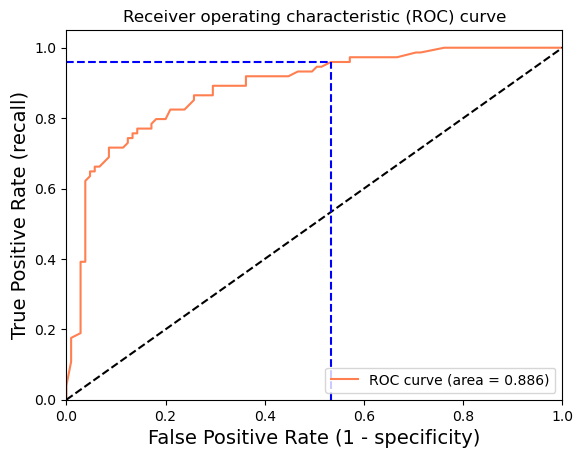

In [420]:
ROC(train2)

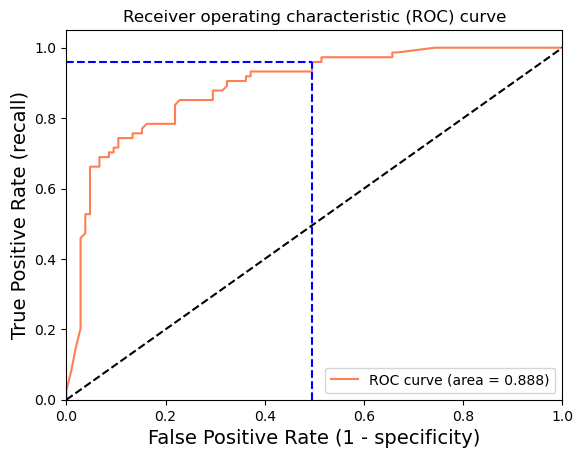

In [422]:
ROC(train3)